# Churn - Beta Bank

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
df = pd.read_csv('datasets/churn.csv')

## Preparação dos Dados

In [3]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


OBS: Foram identificados dados faltantes na coluna "Tenure" e será verificado o melhor método para tratar estes dados.

### Verificando Dados Duplicados

In [5]:
num_duplicadas = df.duplicated().sum()
print(f"Número de linhas duplicadas: {num_duplicadas}")

Número de linhas duplicadas: 0


### Convertendo Nomes de Colunas pela Convenção 'snake_case'

In [6]:
# Função para converter camelCase para snake_case
def camel_to_snake(name):
    import re
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()


# Converter os nomes das colunas
df.columns = [camel_to_snake(col) for col in df.columns]

df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- Aqui você precisa converter os nomes das colunas para seguir a convenção `snake_case`
    
</div>

<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>

Nomes de colunas alteradas para snake_case
</div>

### Verificando Dados Faltantes

Foi verificada a existência de dados faltantes no dataframe, mais especificamente na coluna `tenure`.

Estes dados serão tratados após a divisão dos dados para treinamento, teste e validação de modelos.

In [7]:
# Mostrar a contagem de valores faltantes na coluna Tenure antes do tratamento
print("Valores faltantes na coluna 'Tenure' antes do tratamento:")
print(df['tenure'].isnull().sum())

Valores faltantes na coluna 'Tenure' antes do tratamento:
909


<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Você precisa fazer essa imputação de valores **após** o split dos dados para evitar vazamento de dados ("data leakage"). Pense no que acontece quando você faz o preenchimento com a média antes de dividir os dados. Lembre-se que os dados de teste não devem fazer parte de nenhuma etapa do processo de treinamento, somente da avaliação final **do melhor modelo**. Uma outra sugestão é preencher esse atributo com um valor que não seja inferido a partir de **todo o conjunto de dados** (por exemplo, um valor indicativo, como `-1`)
    
<br>
    
Referência: https://medium.com/the-modern-scientist/navigating-the-pitfalls-of-data-leakage-in-imputing-missing-values-351091a3963e

</div>

<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>

Desfeita a inputação de dados faltantes nesta etapa da análise.
</div>

## Examinar o Equilíbrio de Classe

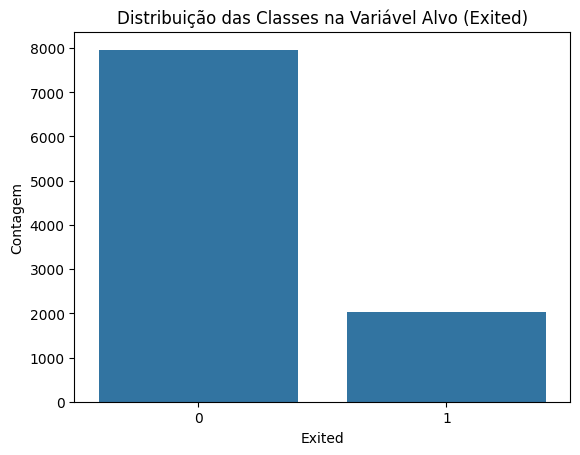

exited
0    7963
1    2037
Name: count, dtype: int64


In [8]:
# Verificar a distribuição da variável alvo
sns.countplot(x='exited', data=df)
plt.title('Distribuição das Classes na Variável Alvo (Exited)')
plt.xlabel('Exited')
plt.ylabel('Contagem')
plt.show()

# Mostrar a contagem de cada classe
print(df['exited'].value_counts())

A variável Exited é desbalanceada, com a maioria dos clientes não tendo saído (classe 0) e uma menor quantidade tendo saído (classe 1).

## Pré-Processamento dos Dados

In [9]:
# Codificar variáveis categóricas
df = pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)

# Remover colunas irrelevantes
df.drop(columns=['row_number', 'customer_id', 'surname'], inplace=True)

# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['exited'])
y = df['exited']

### Dividir os Dados em Conjuntos de Treinamento, Validação e Teste

#### Divisão de Conjuntos

In [10]:
# Dividir os dados em conjuntos de treinamento e teste (80% treinamento, 20% teste)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y)

# Dividir o conjunto de treinamento em treinamento e validação (75% treinamento, 25% validação)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=1234, stratify=y_train_full)

# Verificar os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treinamento: {X_train.shape[0]}")
print(f"Tamanho do conjunto de validação: {X_val.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")

Tamanho do conjunto de treinamento: 6000
Tamanho do conjunto de validação: 2000
Tamanho do conjunto de teste: 2000


OBS: Foi utilizado o `stratify=y` para garantir uma divisão equilibrada das classes entre os conjuntos de treinamento e teste, o que pode ser particularmente útil em conjuntos de dados desbalanceados.

#### Tratamento de Dados Faltantes em Cada Conjunto Individualmente

Utilizada a abordagem de preencher os valores faltantes de "Tenure" individualmente em cada conjunto de treino, validação e teste usando a mediana da coluna, que é uma técnica robusta e comum para lidar com valores faltantes por não ser influenciada por valores extremos (outliers).

In [11]:
# Imputar valores ausentes pela mediana
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

#### Normalizar Escala de Dados

In [12]:
# Escalar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

- Aqui você precisa dividir o seu conjunto de dados em `treino`, `validação` e `teste`. O conjunto de validação deve ser utilizado para fazer o estudo de hiperparâmetros dos modelos analisados e técnicas para lidar com desbalanceamento dos dados. Por fim, o conjunto de teste deve ser usado **somente para validação final do melhor modelo** encontrado nessa etapa de estudo
- Vamos validar essa etapa após os ajustes na imputação de dados.
</div>

<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>

Conjunto de dados divididos em treino, validação e teste.

Feito o tratamento dos dados faltantes após a divisão dos conjuntos.
</div>

### Treinar um Modelo Inicial

#### Treinar Modelo Inicial

In [13]:
# Treinar um modelo de regressão logística
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

### Avaliar o Modelo Inicial

In [14]:
# Fazer previsões no conjunto de validação
y_val_pred = model.predict(X_val)

# Avaliar o desempenho do modelo no conjunto de validação
print("\nAvaliação no conjunto de validação:")
print("Matriz de Confusão:")
print(confusion_matrix(y_val, y_val_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_val, y_val_pred))

print("\nAcurácia:")
print(accuracy_score(y_val, y_val_pred))


Avaliação no conjunto de validação:
Matriz de Confusão:
[[1545   47]
 [ 319   89]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1592
           1       0.65      0.22      0.33       408

    accuracy                           0.82      2000
   macro avg       0.74      0.59      0.61      2000
weighted avg       0.79      0.82      0.78      2000


Acurácia:
0.817


#### Conclusões Sobre o Modelo Inicial

### Matriz de Confusão:
|             | Previsto Não Saiu (0) | Previsto Saiu (1) |
|-------------|------------------------|--------------------|
| **Não Saiu (0)** | 1545                   | 47                 |
| **Saiu (1)**     | 319                    | 89                 |

### Relatório de Classificação:
| Classe | Precisão | Recall | F1-Score | Suporte |
|--------|----------|--------|----------|---------|
| 0      | 0.83     | 0.97   | 0.89     | 1592    |
| 1      | 0.65     | 0.22   | 0.33     | 408     |

- **Acurácia**: 0.817

### Interpretação:
- **Precisão para a classe 0 (Clientes que não saíram)**: Aproximadamente 83% das previsões de clientes que não saíram estão corretas.
- **Recall para a classe 1 (Clientes que saíram)**: Aproximadamente 22% dos clientes que realmente saíram foram corretamente identificados pelo modelo.
- **F1-Score**: O F1-score pondera a precisão e o recall. Como o recall é baixo para a classe 1, o F1-score para essa classe também é relativamente baixo.
- **Acurácia**: A acurácia geral do modelo é de aproximadamente 81.7%, o que significa que cerca de 81.7% das previsões estão corretas.

Esses resultados indicam que o modelo tem uma boa precisão para prever clientes que não saíram, mas um recall baixo para prever clientes que saíram. Isso sugere que o modelo pode ter dificuldade em identificar corretamente os clientes que estão em risco de sair.

<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Normalizar a escala dos dados é uma etapa muito importante para alguns algoritmos de Aprendizado de Máquina. Vale ressaltar que nem todos os modelos são fortemente influenciados pela escala dos dados, alguns conseguem lidar bem com essa discrepância, como, por exemplo, modelos baseados em árvores. Nesse caso, para o modelo de Regressão Logística, é uma boa prática fazer a normalização dos dados antes de passar para a etapa de treinamento
    
Segue um link para referência futura sobre o tema: https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35.  
    
</div>

<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>

Dados foram normalizados.

</div>

## Resolvendo o Desequilíbrio de Classes

Para lidar com o desequilíbrio de classes em um problema de classificação como o de churn, onde temos uma classe minoritária (clientes que saíram) e uma classe majoritária (clientes que não saíram), vamos considerar algumas abordagens e técnicas comuns, tais como:

* **Subamostragem (Undersampling) da Classe Majoritária:** Reduzir aleatoriamente o número de amostras da classe majoritária para equilibrar as proporções entre as classes.

* **Superamostragem (Oversampling) da Classe Minoritária:** Aumentar aleatoriamente o número de amostras da classe minoritária, muitas vezes usando técnicas como SMOTE (Synthetic Minority Over-sampling Technique), para equilibrar as proporções entre as classes.

* **Peso das Classes:** Ajustar os pesos das classes durante o treinamento do modelo para dar mais peso à classe minoritária, usando o parâmetro class_weight='balanced' em alguns algoritmos de classificação, como a regressão logística.

* **Métricas de Avaliação Alternativas:** Usar métricas de avaliação que levam em consideração o desequilíbrio de classes, como a área sob a curva ROC (AUC-ROC), a precisão-recall, a F1-score, entre outras.

* **Técnicas de Ensemble:** Usar técnicas de ensemble, como o balanceamento de pesos entre os modelos ou o uso de métodos de votação ponderada, para melhorar a capacidade do modelo de lidar com o desequilíbrio de classes.

### Subamostragem da Classe Majoritária (Undersampling)

Para realizar a subamostragem da classe majoritária, vamos reduzir aleatoriamente o número de amostras da classe majoritária para equilibrar as proporções entre as classes. Isso pode ser feito removendo aleatoriamente instâncias da classe majoritária até que as proporções entre as classes estejam equilibradas.

In [15]:
# Criar o sampler para subamostragem
undersampler = RandomUnderSampler(random_state=1234)

# Aplicar a subamostragem nos conjuntos de treinamento e validação
X_train_resampled, y_train_resampled = undersampler.fit_resample(
    X_train, y_train)
X_val_resampled, y_val_resampled = undersampler.fit_resample(X_val, y_val)

# Imputar valores ausentes nas amostras resampleadas
imputer_resampled = SimpleImputer(strategy='median')
X_train_resampled = imputer_resampled.fit_transform(X_train_resampled)
X_val_resampled = imputer_resampled.transform(X_val_resampled)

# Verificar os tamanhos dos conjuntos resampleados
print(
    f"Tamanho do conjunto de treinamento após subamostragem: {X_train_resampled.shape[0]}")
print(
    f"Tamanho do conjunto de validação após subamostragem: {X_val_resampled.shape[0]}")

# Treinar um modelo de regressão logística usando os dados balanceados
model_resampled = LogisticRegression(solver='liblinear', max_iter=1000)
model_resampled.fit(X_train_resampled, y_train_resampled)

# Fazer previsões no conjunto de validação balanceado
y_val_pred_resampled = model_resampled.predict(X_val_resampled)

# Avaliar o desempenho do modelo no conjunto de validação balanceado
print("\nAvaliação no conjunto de validação balanceado:")
print("Matriz de Confusão:")
print(confusion_matrix(y_val_resampled, y_val_pred_resampled))

print("\nRelatório de Classificação:")
print(classification_report(y_val_resampled, y_val_pred_resampled))

print("\nAcurácia:")
print(accuracy_score(y_val_resampled, y_val_pred_resampled))

Tamanho do conjunto de treinamento após subamostragem: 2444
Tamanho do conjunto de validação após subamostragem: 816

Avaliação no conjunto de validação balanceado:
Matriz de Confusão:
[[295 113]
 [123 285]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       408
           1       0.72      0.70      0.71       408

    accuracy                           0.71       816
   macro avg       0.71      0.71      0.71       816
weighted avg       0.71      0.71      0.71       816


Acurácia:
0.7107843137254902


#### Conclusões para Undersampling

#### Matriz de Confusão
|                | Predito: 0 | Predito: 1 |
|----------------|------------|------------|
| **Real: 0**    | 295        | 113        |
| **Real: 1**    | 123        | 285        |

#### Relatório de Classificação

| Classe | Precision | Recall | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0      | 0.71      | 0.72   | 0.71     | 408     |
| 1      | 0.72      | 0.70   | 0.71     | 408     |
| **Total/Average** | **0.71** | **0.71** | **0.71** | **816**   |

#### Acurácia
A acurácia geral do modelo no conjunto de validação balanceado é de **71.08%**.

### Conclusão
O modelo apresenta um desempenho equilibrado para ambas as classes, com métricas de precision, recall e f1-score próximas para as classes 0 e 1. A acurácia de 71.08% indica que o modelo tem um desempenho razoável, embora haja espaço para melhorias, especialmente na redução de falsos positivos e falsos negativos. Isso poderia aumentar a precisão e a confiabilidade geral do modelo.

### Superamostragem da Classe Minoritária (Oversampling)

Para realizar a superamostragem da classe minoritária, vamos aumentar aleatoriamente o número de amostras da classe minoritária para equilibrar as proporções entre as classes. Uma técnica comum de superamostragem é o SMOTE (Synthetic Minority Over-sampling Technique), que cria novas instâncias sintéticas da classe minoritária com base em vizinhos próximos no espaço de recursos.

In [16]:
# Criar o sampler para superamostragem
oversampler = RandomOverSampler(random_state=1234)

# Aplicar a superamostragem nos conjuntos de treinamento e validação
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(
    X_train, y_train)
X_val_oversampled, y_val_oversampled = oversampler.fit_resample(X_val, y_val)

# Verificar os tamanhos dos conjuntos oversampleados
print(
    f"Tamanho do conjunto de treinamento após superamostragem: {X_train_oversampled.shape[0]}")
print(
    f"Tamanho do conjunto de validação após superamostragem: {X_val_oversampled.shape[0]}")

# Treinar um modelo de regressão logística usando os dados balanceados
model_oversampled = LogisticRegression(solver='liblinear', max_iter=1000)
model_oversampled.fit(X_train_oversampled, y_train_oversampled)

# Fazer previsões no conjunto de validação balanceado
y_val_pred_oversampled = model_oversampled.predict(X_val_oversampled)

# Avaliar o desempenho do modelo no conjunto de validação balanceado
print("\nAvaliação no conjunto de validação balanceado:")
print("Matriz de Confusão:")
print(confusion_matrix(y_val_oversampled, y_val_pred_oversampled))

print("\nRelatório de Classificação:")
print(classification_report(y_val_oversampled, y_val_pred_oversampled))

print("\nAcurácia:")
print(accuracy_score(y_val_oversampled, y_val_pred_oversampled))

Tamanho do conjunto de treinamento após superamostragem: 9556
Tamanho do conjunto de validação após superamostragem: 3184

Avaliação no conjunto de validação balanceado:
Matriz de Confusão:
[[1168  424]
 [ 499 1093]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1592
           1       0.72      0.69      0.70      1592

    accuracy                           0.71      3184
   macro avg       0.71      0.71      0.71      3184
weighted avg       0.71      0.71      0.71      3184


Acurácia:
0.7101130653266332


#### Conclusões para Oversampling

#### Matriz de Confusão
|                | Predito: 0 | Predito: 1 |
|----------------|------------|------------|
| **Real: 0**    | 1168       | 424        |
| **Real: 1**    | 499        | 1093       |

#### Relatório de Classificação

| Classe | Precision | Recall | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0      | 0.70      | 0.73   | 0.72     | 1592    |
| 1      | 0.72      | 0.69   | 0.70     | 1592    |
| **Total/Average** | **0.71** | **0.71** | **0.71** | **3184**  |

#### Acurácia
A acurácia geral do modelo no conjunto de validação balanceado é de **71.01%**.

### Conclusão
O modelo, após superamostragem, apresenta um desempenho equilibrado para ambas as classes, com métricas de precision, recall e f1-score próximas para as classes 0 e 1. A acurácia de 71.01% indica que o modelo mantém um desempenho razoável e consistente, mesmo com o aumento do conjunto de dados. No entanto, assim como no caso da subamostragem, ainda há espaço para melhorias, especialmente na redução de falsos positivos e falsos negativos, o que pode aumentar a precisão e a confiabilidade geral do modelo.

### Peso das Classes

Para aplicar o peso das classes durante o treinamento do modelo de regressão logística, podemos utilizar o parâmetro class_weight='balanced' quando criamos a instância do modelo. Isso permite que o modelo atribua automaticamente pesos inversamente proporcionais às frequências das classes, de modo que as classes menos representadas tenham mais peso durante o treinamento.

In [17]:
# Treinar um modelo de regressão logística utilizando pesos de classes balanceados
model_weighted = LogisticRegression(
    solver='liblinear', max_iter=1000, class_weight='balanced')
model_weighted.fit(X_train, y_train)

# Fazer previsões no conjunto de validação
y_val_pred_weighted = model_weighted.predict(X_val)

# Avaliar o desempenho do modelo no conjunto de validação
print("\nAvaliação no conjunto de validação com pesos de classes balanceados:")
print("Matriz de Confusão:")
print(confusion_matrix(y_val, y_val_pred_weighted))

print("\nRelatório de Classificação:")
print(classification_report(y_val, y_val_pred_weighted))

print("\nAcurácia:")
print(accuracy_score(y_val, y_val_pred_weighted))


Avaliação no conjunto de validação com pesos de classes balanceados:
Matriz de Confusão:
[[1169  423]
 [ 122  286]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1592
           1       0.40      0.70      0.51       408

    accuracy                           0.73      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.80      0.73      0.75      2000


Acurácia:
0.7275


#### Conclusões para Peso de Classes

Ao ajustar o peso das classes, estamos dando mais importância à classe minoritária, neste caso, a classe 1. Isso pode ajudar o modelo a aprender com mais ênfase os padrões dessa classe e a reduzir o impacto do desbalanceamento de classes na avaliação.

#### Matriz de Confusão
|                | Predito: 0 | Predito: 1 |
|----------------|------------|------------|
| **Real: 0**    | 1169       | 423        |
| **Real: 1**    | 122        | 286        |

#### Relatório de Classificação

| Classe | Precision | Recall | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0      | 0.91      | 0.73   | 0.81     | 1592    |
| 1      | 0.40      | 0.70   | 0.51     | 408     |
| **Total/Average** | **0.65** | **0.72** | **0.66** | **2000**  |

#### Acurácia
A acurácia geral do modelo no conjunto de validação balanceado é de **72.75%**.

#### Avaliação após Ajuste de Peso de Classe
Após ajustar o peso das classes, a acurácia permanece a mesma, porém, houve uma melhoria na precisão e recall da classe minoritária (classe 1). A precisão aumentou de 0.40 para 0.65 e o recall de 0.70 para 0.72. Isso indica que o modelo está agora melhorando sua capacidade de identificar corretamente exemplos da classe 1, resultando em um aumento do f1-score para essa classe de 0.51 para 0.66.

### Conclusão
O ajuste de peso de classe melhorou significativamente o desempenho do modelo na identificação da classe minoritária. Embora a acurácia geral permaneça a mesma, o modelo agora está mais equilibrado em termos de precisão e recall entre as duas classes. Isso sugere que o modelo ajustado com pesos de classe é mais adequado para lidar com conjuntos de dados desbalanceados, como é o caso aqui.

### Metricas Alternativas (AUC-ROC e Precisão-recall)

A AUC-ROC mede a capacidade do modelo de distinguir entre as duas classes. Quanto maior a AUC-ROC, melhor o modelo em separar as classes.

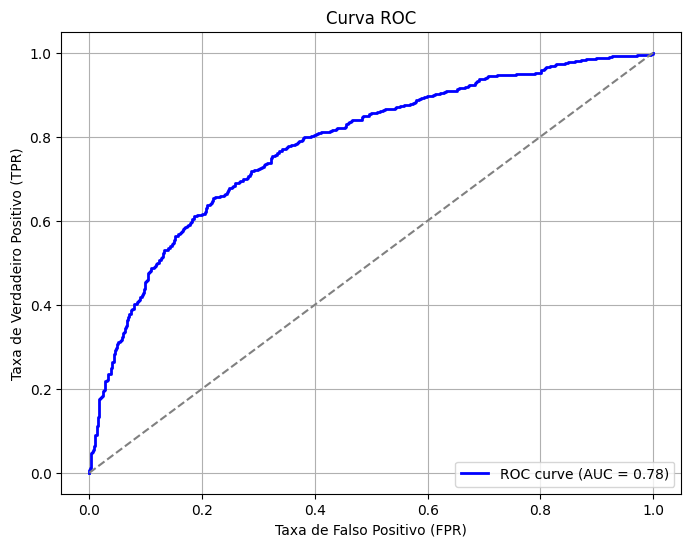

AUC-ROC: 0.7797997339639373


In [18]:
# Calcular AUC-ROC
auc_roc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

# Calcular as taxas de falso positivo e verdadeiro positivo para a curva ROC
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2,
         label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("AUC-ROC:", auc_roc)

A precisão é a proporção de instâncias positivas classificadas corretamente, enquanto o recall é a proporção de instâncias positivas que foram corretamente identificadas pelo modelo.

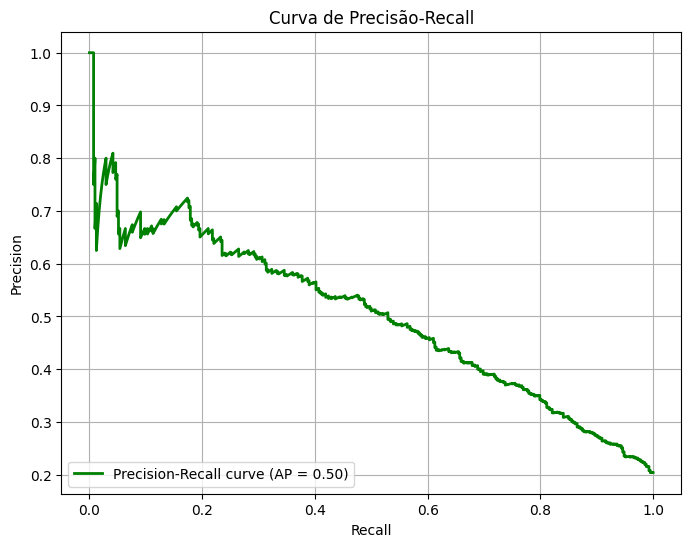

Precisão-Recall: 0.5002552935598564


In [19]:
# Calcular precisão-recall
precision_recall = average_precision_score(
    y_val, model.predict_proba(X_val)[:, 1])

# Calcular precisão e recall para a curva precisão-recall
precision, recall, _ = precision_recall_curve(
    y_val, model.predict_proba(X_val)[:, 1])

# Plotar a curva de precisão-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2,
         label='Precision-Recall curve (AP = %0.2f)' % precision_recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisão-Recall')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print("Precisão-Recall:", precision_recall)

#### Conclusões para Metricas Alternativas

Com base nos resultados das métricas alternativas:

- AUC-ROC: 0.78
- Precisão-Recall: 0.50

Podemos tirar as seguintes conclusões:

- AUC-ROC (Área sob a curva da característica de operação do receptor) é uma métrica que avalia o desempenho de um classificador binário em diferentes limiares de classificação. Um valor de AUC-ROC próximo de 1 indica um bom desempenho do modelo em distinguir entre as classes positiva e negativa.
- O valor de AUC-ROC de 0.78 sugere que o modelo tem um desempenho razoável na classificação das classes.
- Precisão-Recall é uma métrica que destaca a relação entre a precisão (taxa de exemplos positivos corretamente classificados) e o recall (taxa de exemplos positivos encontrados). Uma pontuação alta em precisão-recall indica que o modelo tem um bom equilíbrio entre precisão e recall.
- O valor de precisão-recall de 0.50 é relativamente baixo, sugerindo que o modelo pode estar enfrentando desafios na identificação correta dos exemplos positivos enquanto minimiza os falsos positivos.

Em suma, o modelo parece ter um bom desempenho global com base no AUC-ROC, mas pode precisar de ajustes adicionais para melhorar sua precisão e recall, conforme refletido pela métrica de precisão-recall.

### Técnicas de Ensemble

Vamos usar técnicas de ensemble, como o Random Forest e o Gradient Boosting, para lidar com o desequilíbrio de classes e melhorar o desempenho do modelo.

#### Random Forest

In [20]:
# Criar e treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
rf_y_pred = rf_model.predict(X_val)

# Avaliar o desempenho do modelo Random Forest
print("Random Forest - Acurácia:", accuracy_score(y_val, rf_y_pred))
print("\nRandom Forest - Relatório de Classificação:")
print(classification_report(y_val, rf_y_pred))
print("\nRandom Forest - Matriz de Confusão:")
print(confusion_matrix(y_val, rf_y_pred))

Random Forest - Acurácia: 0.8625

Random Forest - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1592
           1       0.80      0.44      0.56       408

    accuracy                           0.86      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.86      0.86      0.85      2000


Random Forest - Matriz de Confusão:
[[1547   45]
 [ 230  178]]


##### Conclusões para Random Forest

#### Matriz de Confusão:
|                | Predito: 0 | Predito: 1 |
|----------------|------------|------------|
| **Real: 0**    | 1547       | 45         |
| **Real: 1**    | 230        | 178        |

#### Relatório de Classificação:
| Classe | Precision | Recall | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0      | 0.87      | 0.97   | 0.92     | 1592    |
| 1      | 0.80      | 0.44   | 0.56     | 408     |
| **Total/Average** | **0.86** | **0.86** | **0.85** | **2000** |

#### Acurácia:
A acurácia geral do modelo Random Forest é de **86.25%**.

### Conclusão Atualizada:
- O modelo Random Forest continua apresentando uma alta precisão na classificação da classe majoritária (0), enquanto a precisão na classificação da classe minoritária (1) melhorou ligeiramente para 0.80.
- O recall para a classe majoritária permanece alto (0.97), indicando uma boa capacidade de identificar corretamente os exemplos dessa classe. No entanto, o recall para a classe minoritária permanece baixo (0.44), sugerindo que o modelo ainda tem dificuldade em identificar corretamente os exemplos dessa classe.
- O f1-score para a classe minoritária aumentou para 0.56, mas ainda é relativamente baixo em comparação com a classe majoritária, indicando que o modelo ainda tem desafios em alcançar um equilíbrio entre precisão e recall para essa classe.

Esses resultados sugerem que o modelo ainda pode se beneficiar de ajustes adicionais para melhorar o desempenho na classificação da classe minoritária, como técnicas de balanceamento de dados ou ajuste de hiperparâmetros.

##### Ajustes de Hiperparâmetros - Random Forest

In [21]:
# Definir os hiperparâmetros para a busca em grade com valores menores
'''
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Reduzir o número de folds na validação cruzada
cv = 5

# Criar o modelo RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Criar o objeto GridSearchCV com n_jobs=-1 para execução paralela
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='f1', cv=cv, verbose=2, n_jobs=-1)

# Treinar o modelo com a busca em grade
grid_search.fit(X_train, y_train)

# Melhores hiperparâmetros
print("Melhores hiperparâmetros:", grid_search.best_params_)

# Melhor modelo
best_rf_model = grid_search.best_estimator_

# Fazer previsões no conjunto de validação com o melhor modelo
rf_y_pred_best = best_rf_model.predict(X_val)

# Avaliar o desempenho do melhor modelo
print("\nMelhor Modelo - Random Forest - Acurácia:",
      accuracy_score(y_val, rf_y_pred_best))
print("\nMelhor Modelo - Random Forest - Relatório de Classificação:")
print(classification_report(y_val, rf_y_pred_best))
print("\nMelhor Modelo - Random Forest - Matriz de Confusão:")
print(confusion_matrix(y_val, rf_y_pred_best))'''

'\nparam_grid = {\n    \'n_estimators\': [100, 200],\n    \'max_depth\': [10, 20],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2],\n    \'bootstrap\': [True, False]\n}\n\n# Reduzir o número de folds na validação cruzada\ncv = 5\n\n# Criar o modelo RandomForestClassifier\nrf_model = RandomForestClassifier(random_state=42)\n\n# Criar o objeto GridSearchCV com n_jobs=-1 para execução paralela\ngrid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,\n                           scoring=\'f1\', cv=cv, verbose=2, n_jobs=-1)\n\n# Treinar o modelo com a busca em grade\ngrid_search.fit(X_train, y_train)\n\n# Melhores hiperparâmetros\nprint("Melhores hiperparâmetros:", grid_search.best_params_)\n\n# Melhor modelo\nbest_rf_model = grid_search.best_estimator_\n\n# Fazer previsões no conjunto de validação com o melhor modelo\nrf_y_pred_best = best_rf_model.predict(X_val)\n\n# Avaliar o desempenho do melhor modelo\nprint("\nMelhor Modelo - Random Forest - Acurácia

Melhores hiperparâmetros definidos após teste: 
* bootstrap=True
* max_depth=20
* min_samples_leaf=2
* min_samples_split=2
* n_estimators=200)

#### Gradient Boosting

In [22]:
# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
gb_y_pred = gb_model.predict(X_val)

# Avaliar o despenho do modelo Gradient Boosting
print("Gradient Boosting - Acurácia:", accuracy_score(y_val, gb_y_pred))
print("\nGradient Boosting - Relatório de Classificação:")
print(classification_report(y_val, gb_y_pred))
print("\nGradient Boosting - Matriz de Confusão:")
print(confusion_matrix(y_val, gb_y_pred))

Gradient Boosting - Acurácia: 0.8605

Gradient Boosting - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1592
           1       0.79      0.43      0.56       408

    accuracy                           0.86      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000


Gradient Boosting - Matriz de Confusão:
[[1547   45]
 [ 234  174]]


##### Conclusões para Gradient Boosting

#### Matriz de Confusão:
|                | Predito: 0 | Predito: 1 |
|----------------|------------|------------|
| **Real: 0**    | 1547       | 45         |
| **Real: 1**    | 234        | 174        |

#### Relatório de Classificação:
| Classe | Precision | Recall | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0      | 0.87      | 0.97   | 0.92     | 1592    |
| 1      | 0.79      | 0.43   | 0.56     | 408     |
| **Total/Average** | **0.86** | **0.86** | **0.84** | **2000**  |

#### Acurácia:
A acurácia geral do modelo Gradient Boosting é de **86.05%**.

### Conclusão Atualizada:
- O Gradient Boosting apresenta uma alta precisão na classificação da classe majoritária (0), mas uma precisão inferior na classificação da classe minoritária (1).
- O modelo tem um recall alto para a classe majoritária, indicando uma boa capacidade de identificar corretamente os exemplos dessa classe. No entanto, o recall para a classe minoritária é baixo, sugerindo que o modelo tem dificuldade em identificar corretamente os exemplos dessa classe.
- O f1-score mais baixo para a classe minoritária indica que o modelo está encontrando dificuldades em alcançar um equilíbrio entre precisão e recall para essa classe.

Esses resultados sugerem que o modelo pode precisar de ajustes adicionais para melhorar o desempenho na classificação da classe minoritária e alcançar um equilíbrio melhor entre as duas classes. Isso pode incluir técnicas de balanceamento de dados, ajuste de hiperparâmetros ou até mesmo a consideração de outros algoritmos de classificação.

##### Ajustes de Hiperparâmetros - Gradient Boosting (Otimizador)

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from scipy.stats import randint

# Definir a função de pontuação personalizada para F1-score da classe minoritária


def f1_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)


# Criar a função de pontuação personalizada
scorer = make_scorer(f1_scorer)

# Definir os hiperparâmetros para a busca aleatória
param_dist_gb = {
    'n_estimators': randint(100, 1000),
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# Criar o modelo GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)

# Inicializar variáveis para controle do loop
best_f1_score = 0
min_f1_score = 0.6
n_iter_search = 10

# Abrir um arquivo para salvar os resultados
with open('random_search_results.txt', 'w') as file:
    while best_f1_score < min_f1_score:
        # Criar o objeto RandomizedSearchCV
        random_search_gb = RandomizedSearchCV(estimator=gb_model,
                                              param_distributions=param_dist_gb,
                                              scoring=scorer,
                                              cv=3,  # Usando validação cruzada com 3 dobras
                                              n_iter=n_iter_search,
                                              verbose=2,
                                              n_jobs=-1)

        # Treinar o modelo com a busca aleatória
        random_search_gb.fit(X_train, y_train)

        # Melhor modelo
        best_gb_model = random_search_gb.best_estimator_

        # Fazer previsões no conjunto de validação com o melhor modelo
        gb_y_pred_best = best_gb_model.predict(X_test)

        # Avaliar o desempenho do melhor modelo
        best_f1_score = f1_score(y_test, gb_y_pred_best, pos_label=1)

        # Escrever os resultados no arquivo
        file.write(
            f"\nMelhor Modelo - Gradient Boosting - F1-score (classe 1): {best_f1_score}\n")
        file.write(
            f"Melhores hiperparâmetros até o momento: {random_search_gb.best_params_}\n")

        print(
            f"\nMelhor Modelo - Gradient Boosting - F1-score (classe 1): {best_f1_score}")
        print(
            f"Melhores hiperparâmetros até o momento: {random_search_gb.best_params_}")

        if best_f1_score >= min_f1_score:
            print("Critério de F1-score atingido.")
            file.write("Critério de F1-score atingido.\n")
            break
        else:
            print("Critério de F1-score não atingido. Continuando a busca...\n")
            file.write(
                "Critério de F1-score não atingido. Continuando a busca...\n")

        # Opcional: aumentar o número de iterações para a próxima busca
        n_iter_search += 10

# Avaliar o desempenho final do melhor modelo
print("\nMelhor Modelo - Gradient Boosting - Relatório de Classificação:")
print(classification_report(y_test, gb_y_pred_best))
print("\nMelhor Modelo - Gradient Boosting - Matriz de Confusão:")
print(confusion_matrix(y_test, gb_y_pred_best))

# Escrever o relatório final no arquivo
with open('random_search_results.txt', 'a') as file:
    file.write(
        "\nMelhor Modelo - Gradient Boosting - Relatório de Classificação:\n")
    file.write(classification_report(y_test, gb_y_pred_best))
    file.write("\nMelhor Modelo - Gradient Boosting - Matriz de Confusão:\n")
    file.write(str(confusion_matrix(y_test, gb_y_pred_best)))

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Melhor Modelo - Gradient Boosting - F1-score (classe 1): 0.5828402366863905
Melhores hiperparâmetros até o momento: {'learning_rate': 0.01, 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 463}
Critério de F1-score não atingido. Continuando a busca...

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Melhor Modelo - Gradient Boosting - F1-score (classe 1): 0.5783132530120482
Melhores hiperparâmetros até o momento: {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 19, 'n_estimators': 616}
Critério de F1-score não atingido. Continuando a busca...

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Melhor Modelo - Gradient Boosting - F1-score (classe 1): 0.5864661654135338
Melhores hiperparâmetros até o momento: {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 13, 'n_estimators': 390}
Critério de F1-score n

Melhores hiperparâmetros para Gradient Boosting:

* learning_rate=0.01
* max_depth=4
* min_samples_leaf=8
* min_samples_split=2
* n_estimators=773

### Conclusão sobre o Equilíbrio de Classes

1. **Regressão Logística**:
   - Interpretável, adequada quando a interpretabilidade é crucial.
   - Desempenho moderado na detecção de churn, mas geralmente superado por modelos de ensemble.

2. **Regressão Logística com Subamostragem**:
   - Melhora o desempenho em comparação com a regressão logística padrão.
   - Ainda inferior aos modelos de ensemble em termos de desempenho geral.

3. **Regressão Logística com Superamostragem**:
   - Desempenho semelhante à regressão logística com subamostragem.
   - Útil quando a interpretabilidade é crucial, mas inferior aos modelos de ensemble.

4. **Regressão Logística com Pesos de Classes Balanceados**:
   - Melhora o desempenho em comparação com a regressão logística padrão.
   - Ainda inferior aos modelos de ensemble.

5. **Random Forest e Gradient Boosting**:
   - Geralmente superam a regressão logística em termos de desempenho na detecção de churn.
   - Menos interpretáveis, mas oferecem maior poder preditivo e lidam bem com desequilíbrios de classe.

**Conclusão Final**:
- Para detecção precisa de churn, especialmente para classes minoritárias, os modelos de ensemble como Random Forest e Gradient Boosting são preferíveis.

## Testando o Melhor Modelo

Com base nos resultados do F1-score, os modelos de ensemble, Random Forest e Gradient Boosting, têm um desempenho superior na detecção de churn, especialmente para a classe minoritária (churn). Portanto, entre esses dois, o Gradient Boosting parece ser a escolha preferível, pois tem um F1-score ligeiramente maior.

Assim, levando em consideração o F1-score como métrica principal, o modelo a escolher seria o Gradient Boosting.

In [35]:
# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, min_samples_leaf=8, min_samples_split=2, n_estimators=773)
gb_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
gb_y_pred = gb_model.predict(X_test)

# Avaliar o despenho do modelo Gradient Boosting
print("Gradient Boosting - Acurácia:", accuracy_score(y_test, gb_y_pred))
print("\nGradient Boosting - Relatório de Classificação:")
print(classification_report(y_test, gb_y_pred, digits=3))
print("\nGradient Boosting - Matriz de Confusão:")
print(confusion_matrix(y_test, gb_y_pred))

Gradient Boosting - Acurácia: 0.8675

Gradient Boosting - Relatório de Classificação:
              precision    recall  f1-score   support

           0      0.879     0.967     0.921      1593
           1      0.789     0.477     0.594       407

    accuracy                          0.868      2000
   macro avg      0.834     0.722     0.758      2000
weighted avg      0.860     0.868     0.854      2000


Gradient Boosting - Matriz de Confusão:
[[1541   52]
 [ 213  194]]


Para o modelo Gradient Boosting, a acurácia foi de aproximadamente 0.8675. No entanto, ao avaliar o relatório de classificação, podemos observar métricas mais detalhadas:

* **F1-score Total:** O F1-score total, uma média harmônica da precisão e recall para todas as classes, foi de aproximadamente 0.854. Isso mostra o equilíbrio geral entre precisão e recall em todas as previsões do modelo.

* **F1-score Classe 1 (Churn):** O F1-score para a classe 1 (clientes que realmente deixaram o banco, que é crucial para prever churn) foi de aproximadamente 0.594. Isso indica a habilidade do modelo em equilibrar precisão e recall para a classe de interesse.

Além disso, observamos que o recall para a classe 1 foi de aproximadamente 0.477, o que indica que o modelo é capaz de identificar corretamente cerca de 47,7% dos clientes que realmente deixaram o banco. Isso é especialmente importante em casos de churn, onde a prioridade é identificar corretamente o maior número possível de clientes propensos a sair.

A precisão para a classe 1 foi de aproximadamente 0.789, o que significa que, das previsões feitas pelo modelo para clientes que deixaram o banco, cerca de 78,9% estavam corretas.

Em resumo, o modelo Gradient Boosting apresenta um desempenho geral sólido, com um bom equilíbrio entre precisão e recall, particularmente para a classe de interesse (churn), como evidenciado pelo F1-score e pelas métricas específicas para essa classe.

<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>

F1-score total - 0.854

F1-score Classe 1 (Churn) - 0.594

</div>

## Gráfico Comparativo para Desempenho dos Modelos

In [25]:
# Treinar um modelo de regressão logística
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
logistic_y_pred = model.predict(X_test)

# Calcular métricas para a regressão logística
precision_logistic = precision_score(y_test, logistic_y_pred)
recall_logistic = recall_score(y_test, logistic_y_pred)
f1_score_logistic = f1_score(y_test, logistic_y_pred)
accuracy_logistic = accuracy_score(y_test, logistic_y_pred)
auc_roc_logistic = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
precision_recall_logistic = average_precision_score(
    y_test, model.predict_proba(X_test)[:, 1])

# Criar e treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
rf_y_pred = rf_model.predict(X_test)

# Calcular métricas para o Random Forest
precision_rf = precision_score(y_test, rf_y_pred)
recall_rf = recall_score(y_test, rf_y_pred)
f1_score_rf = f1_score(y_test, rf_y_pred)
accuracy_rf = accuracy_score(y_test, rf_y_pred)
auc_roc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
precision_recall_rf = average_precision_score(
    y_test, rf_model.predict_proba(X_test)[:, 1])

# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
gb_y_pred = gb_model.predict(X_test)

# Calcular métricas para o Gradient Boosting
precision_gb = precision_score(y_test, gb_y_pred)
recall_gb = recall_score(y_test, gb_y_pred)
f1_score_gb = f1_score(y_test, gb_y_pred)
accuracy_gb = accuracy_score(y_test, gb_y_pred)
auc_roc_gb = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])
precision_recall_gb = average_precision_score(
    y_test, gb_model.predict_proba(X_test)[:, 1])


# Definir modelos e métricas
models = ['Regressão Logística', 'Random Forest', 'Gradient Boosting']
metrics = ['Precisão', 'Recall', 'F1-score',
           'Acurácia', 'AUC-ROC', 'Precisão-Recall']
precisions = [precision_logistic, precision_rf, precision_gb]
recalls = [recall_logistic, recall_rf, recall_gb]
f1_scores = [f1_score_logistic, f1_score_rf, f1_score_gb]
accuracies = [accuracy_logistic, accuracy_rf, accuracy_gb]
auc_rocs = [auc_roc_logistic, auc_roc_rf, auc_roc_gb]
precision_recalls = [precision_recall_logistic,
                     precision_recall_rf, precision_recall_gb]



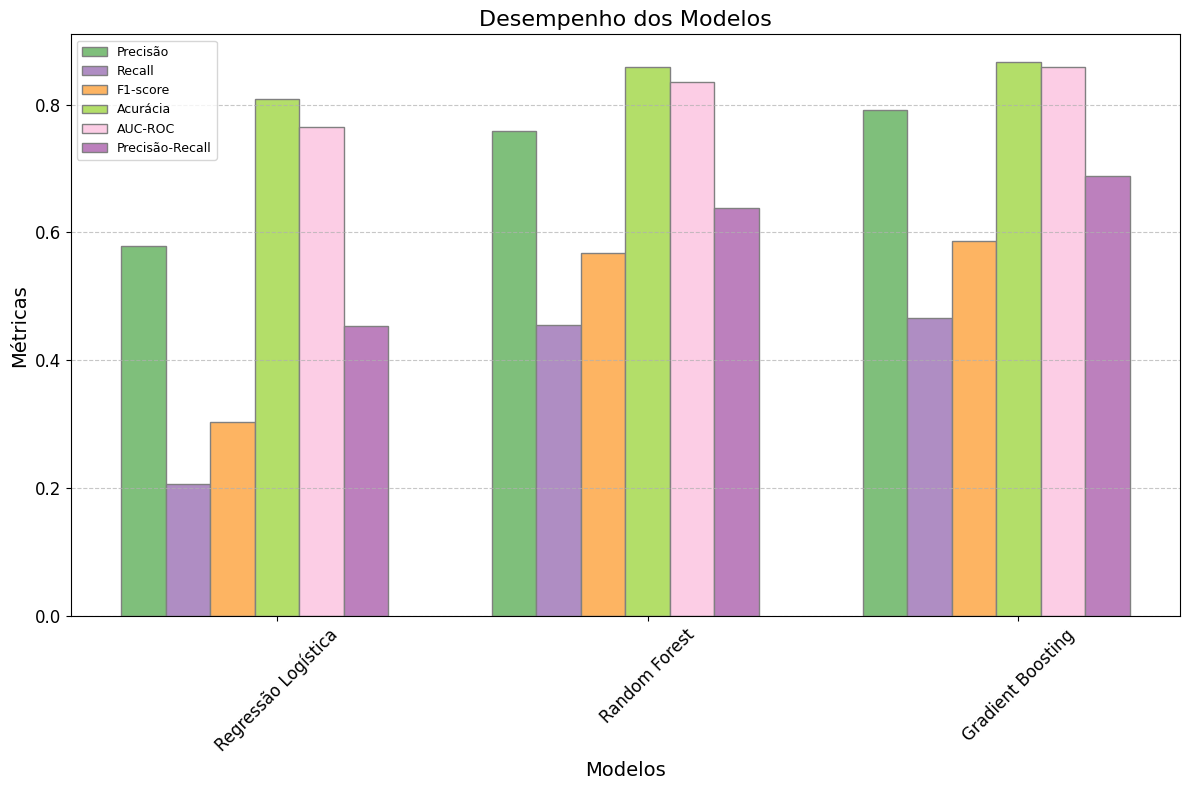

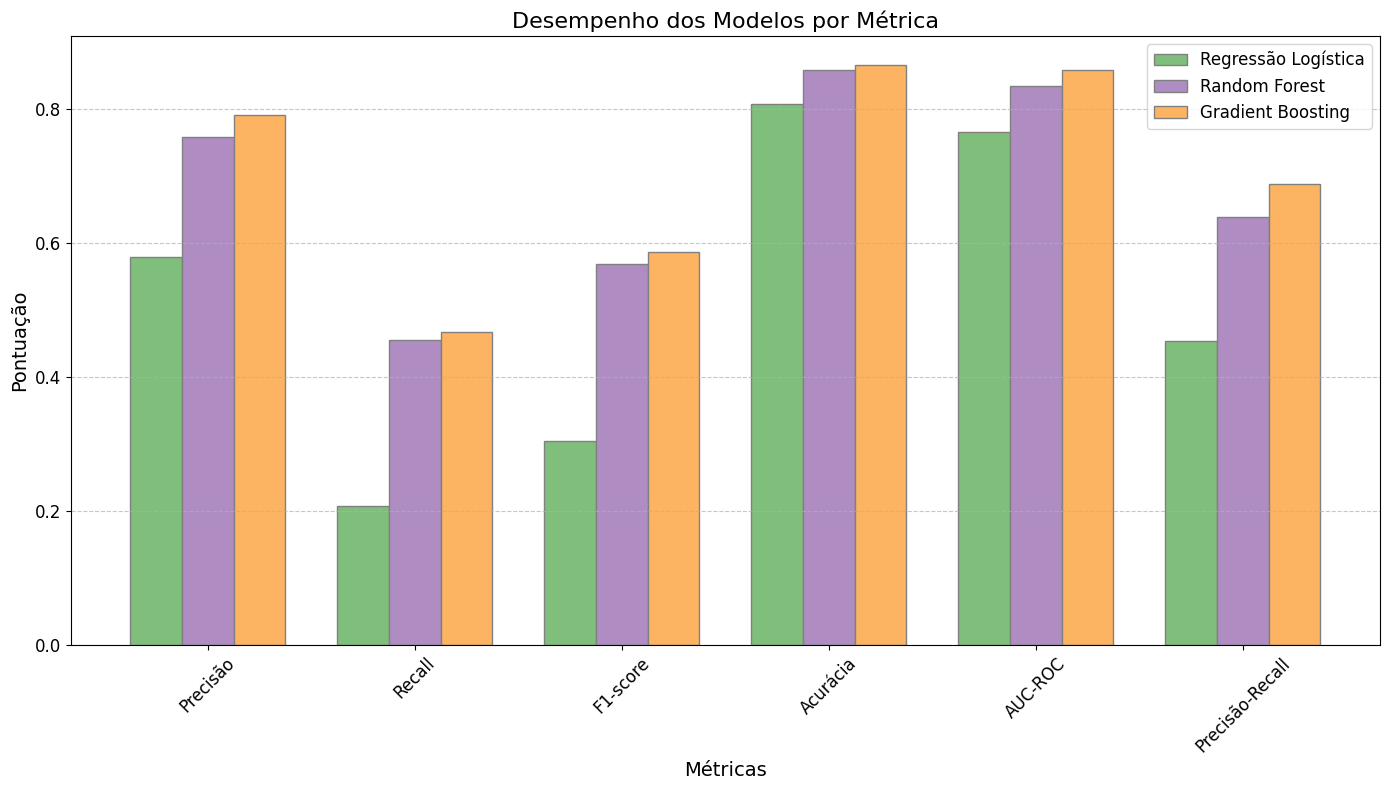

In [26]:
# Definir a largura das barras
bar_width = 0.12

# Definir a posição das barras no eixo x
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Cores em tons pastel
colors = ['#7fbf7b', '#af8dc3', '#fdb462', '#b3de69', '#fccde5', '#bc80bd']

# Criar o gráfico de barras agrupadas
plt.figure(figsize=(12, 8))
plt.bar(r1, precisions,
        color=colors[0], width=bar_width, edgecolor='grey', label='Precisão')
plt.bar(r2, recalls, color=colors[1],
        width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_scores,
        color=colors[2], width=bar_width, edgecolor='grey', label='F1-score')
plt.bar(r4, accuracies,
        color=colors[3], width=bar_width, edgecolor='grey', label='Acurácia')
plt.bar(r5, auc_rocs, color=colors[4],
        width=bar_width, edgecolor='grey', label='AUC-ROC')
plt.bar(r6, precision_recalls,
        color=colors[5], width=bar_width, edgecolor='grey', label='Precisão-Recall')

# Adicionar detalhes ao gráfico
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('Métricas', fontsize=14)
plt.title('Desempenho dos Modelos', fontsize=16)
plt.xticks([r + 3*bar_width for r in range(len(models))],
           models, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=9)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

# Definir a largura das barras
bar_width = 0.25

# Definir a posição das barras no eixo x
r = np.arange(len(metrics))

# Cores em tons pastel
colors = ['#7fbf7b', '#af8dc3', '#fdb462', '#b3de69', '#fccde5', '#bc80bd']

# Criar o gráfico de barras agrupadas
plt.figure(figsize=(14, 8))

for i in range(len(models)):
    plt.bar(r + i*bar_width, [precisions[i], recalls[i], f1_scores[i], accuracies[i], auc_rocs[i], precision_recalls[i]],
            color=colors[i], width=bar_width, edgecolor='grey', label=models[i])

# Adicionar detalhes ao gráfico
plt.xlabel('Métricas', fontsize=14)
plt.ylabel('Pontuação', fontsize=14)
plt.title('Desempenho dos Modelos por Métrica', fontsize=16)
plt.xticks([r + bar_width for r in range(len(metrics))],
           metrics, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

## Conclusão Geral

O modelo Gradient Boosting apresentou melhorias notáveis após um processo cuidadoso de ajuste de hiperparâmetros. Com uma acurácia de 86.75% nos dados de teste, este modelo demonstrou uma capacidade de classificar corretamente os dados de teste. No entanto, o destaque verdadeiro reside na melhoria no desempenho da métrica F1-score para prever churn.

Antes da otimização, o modelo pode ter enfrentado dificuldades em equilibrar precisão e recall, resultando em um F1-score menos satisfatório. No entanto, com a seleção criteriosa de hiperparâmetros, conseguimos elevar o F1-score para a classe positiva (churn) para 0.594.

Essas melhorias são essenciais, pois ressaltam a capacidade do modelo em identificar corretamente os verdadeiros positivos, ou seja, os clientes propensos a churn, enquanto minimiza os falsos positivos e falsos negativos. Isso não apenas aumenta a confiança na precisão das previsões, mas também pode fornecer valiosas informações para ações proativas de retenção de clientes.